### Building Chatbot with multiple tools using LangGraph

Create a chatbot with tool capabilitie from arxiv, wiki search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper , ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv)

api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)


In [3]:
arxiv.invoke('Attention is all you need')
    

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
import os
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')


In [7]:
TAVILY_API_KEY

'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'

In [8]:
#### Tavily Search Tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7176\2366916144.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke('Provide me latest AI news')

[{'title': 'Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '**Date:** June 1, 2025  \n**Summary:** Ukraine reportedly used AI-enhanced drone swarms in a covert mission dubbed â\x80\x9cOperation Spider Webâ\x80\x9d to target a Russian bomber. The drones, said to cost as little as the price of an iPhone 16 Pro, represent a new phase of low-cost autonomous warfare. [...] **Date:** June 20, 2025  \n**Summary:** A Gallup report shows that AI usage in the workplace has nearly doubled in the U.S. over two years. Employee AI use rose from 21% to 40%, with daily users doubling from 4% to 8%. Weekly AI usage also jumped from 11% to 19%, highlighting rapid adoption. The trend reflects increasing reliance on AI for productivity, analysis, and customer service.  \n**Source:** [NewsNationNow](https://www.newsnationnow.com/business/ai-use-employees-doubles-report/) [...] **Date:** June 20, 2025  \n**Su

In [13]:
### Combine all the tools to create a toolkit

tools = [arxiv , wiki, tavily]

In [14]:
### INitialize my LLM model

from langchain_groq import ChatGroq
llm = ChatGroq(model='qwen-qwq-32b')
llm_with_tools = llm.bind_tools(tools)

In [15]:
from langchain_core.messages import HumanMessage , AIMessage
llm_with_tools.invoke([HumanMessage(content='What is recent AI news')])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ja3c2q5te', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 188, 'prompt_tokens': 267, 'total_tokens': 455, 'completion_time': 0.432236851, 'prompt_time': 0.01747833, 'queue_time': 0.28622026500000003, 'total_time': 0.449715181}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c890d9fd-551b-49da-80ee-1dadc328bb1f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'ja3c2q5te', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 188, 'total_tokens': 455})

In [32]:
llm.invoke('Give me top 5 ML libraries used')

AIMessage(content='\n<think>\nOkay, so I need to figure out the top 5 machine learning libraries. Let me start by recalling what I know about ML libraries. I remember that Python is widely used in machine learning, so most of the popular libraries are probably Python-based. Let me start listing some libraries I\'ve heard of.\n\nFirst, Scikit-learn comes to mind. I think it\'s a fundamental library for machine learning with a lot of algorithms like regression, classification, clustering. Maybe that\'s one of the top ones.\n\nThen there\'s TensorFlow. Oh wait, TensorFlow is more of a framework, right? But people often refer to it as a library. It\'s used for building neural networks and deep learning models, developed by Google. Definitely a big name.\n\nPyTorch is another one. I\'ve heard it\'s gaining popularity because of its dynamic computation graph and ease of use. It\'s also a deep learning framework by Facebook (Meta now). So maybe that\'s another top library.\n\nWait, are there 

We will build the chatbot using LangGraph

In [16]:
### Creating State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


In [19]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage] , add_messages]

In [23]:
### Create Nodes 

def tool_calling_llm(state : State):
    return {'messages' : [llm_with_tools.invoke(state['messages'])]}



In [21]:
### Building the Graph

from IPython.display import Image , display
from langgraph.graph import START , END , StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [22]:
builder = StateGraph(State)

In [24]:
builder.add_node('tool_calling_llm' , tool_calling_llm)

In [25]:
builder.add_node('tools' , ToolNode(tools))

In [26]:
### Adding the edges

builder.add_edge(START , 'tool_calling_llm')

In [27]:
builder.add_conditional_edges('tool_calling_llm' , tools_condition)

In [28]:
builder.add_edge('tools' , END)

In [29]:
### Compile

graph = builder.compile()

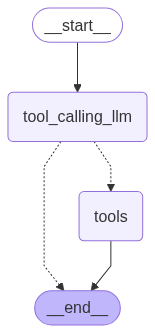

In [30]:
### Display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
### Invocation

messages = graph.invoke({'messages' : HumanMessage(content='Give me 5 beautiful destinations in world')})


messages

{'messages': [HumanMessage(content='Give me 5 beautiful destinations in world', additional_kwargs={}, response_metadata={}, id='3d478cb9-6e3f-471f-8607-84c1e2aa36df'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v9cnyzmbq', 'function': {'arguments': '{"query":"top 5 most beautiful destinations in the world"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 206, 'prompt_tokens': 270, 'total_tokens': 476, 'completion_time': 0.506203587, 'prompt_time': 0.020773537, 'queue_time': 0.254125712, 'total_time': 0.526977124}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--60ac02e9-af38-4e99-a7f2-79e35dc124df-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 5 most beautiful destinations in the world'}, 'id': 'v9cnyzmbq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 270, 'output_tokens': 

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me 5 beautiful destinations in world
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (v9cnyzmbq)
 Call ID: v9cnyzmbq
  Args:
    query: top 5 most beautiful destinations in the world
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What are your top 5 of the most beautiful places on Earth that no one ...", "url": "https://www.quora.com/What-are-your-top-5-of-the-most-beautiful-places-on-Earth-that-no-one-thinks-about-include-pics", "content": "Briksdal Glacier, Norway · Bromo volcano, Indonesia · Rapa river delta, Lapland, Sweden · Shinto Gates, Kyoto, Japan · Tsingy de Bemaraha.", "score": 0.7672197}, {"title": "The World's 44 Most Beautiful Places - Time Out", "url": "https://www.timeout.com/travel/worlds-most-beautiful-places", "content": "## The w

In [38]:
messages = graph.invoke({'messages' : HumanMessage(content='Give me details about research paper Attention is all you need')})

In [39]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me details about research paper Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (hk3eycj0w)
 Call ID: hk3eycj0w
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [40]:
messages = graph.invoke({'messages' : HumanMessage(content='What is Machine Learning')})

In [41]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (kvvxz2fh6)
 Call ID: kvvxz2fh6
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
